# CNN-based Lung CT Images Classification
## Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1' " before "from keras.preprocessing.image import ImageDataGenerator"

In [1]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow
import cv2

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

#要用哪个模型就取消注释符号
#1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

#2
#from tensorflow.keras.applications.resnet import ResNet50
#from tensorflow.keras.applications.resnet import preprocess_input

#3
#from keras.applications.densenet import DenseNet121
#from keras.applications.densenet import preprocess_input

#4
##from tensorflow.keras.applications import EfficientNetB0
##from tensorflow.keras.applications.resnet import preprocess_input

#5
#from tensorflow.keras.applications import MobileNet
#from tensorflow.keras.applications.resnet import preprocess_input

from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import KFold
from tensorflow import keras
import csv


##配置GPU
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

model = keras.models.load_model("trained_model.h5")

IMG_SIZE = (224,224)
def load_data(dir_path,img_size=IMG_SIZE):
    X=[]
    y=[]
    file_name=[]
    i=0
    for file in os.listdir(dir_path):
        if not file.startswith('.'):
            img=cv2.imread(dir_path+'/'+file)
            img=cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
            X.append(preprocess_input(img))
            y.append(i)
            file_name.append(file.split('.')[0])
    i+=1
    X=np.array(X)
    y=np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X,y,file_name
        
VAL_DIR="test/"
X_val,y_val,file_name=load_data(VAL_DIR)
predictions=model.predict(X_val)
predictions=[1 if x>0.5 else 0 for x in predictions]
data=zip(file_name,predictions)
with open("result.csv","w",newline="") as f:
    writer=csv.writer(f)
    writer.writerows(data)
        

93 images loaded from test/ directory.
3/3 [==============================] - 22s 5s/step


## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [2]:
#uncomment if using linux/macos
#!rm -rf Train_covid Val_covid
#!mkdir Train_covid Val_covid Train_covid/yes Train_covid/no Val_covid/yes Val_covid/no

#uncomment if using windows
!rmdir Train_covid Val_covid /s /q
#!md Train_covid Val_covid Train_covid\yes Train_covid\no Val_covid\yes Val_covid\no
!md Train_covid Val_covid Train_covid\yes Train_covid\no Val_covid\yes Val_covid\no

##数据集分成training（测试集）和validation set（验证集）。目的是为了防止过度拟合出现，在这分成了5份，其中4份
##是training sets，剩下的是validation set。可以展示不同量度的训练集和损失之间的图像。

##如果只有训练集和测试集（显然，这样是不可行的，因为测试集必须是我们从未见过的数据）
##用训练集训练出各个模型后，用测试集选出其中最好的模型（我们把此模型称为gm*-），
##记录最好模型的各项设置（比如说使用哪个算法，迭代次数是几次，学习速率是多少，
##特征转换的方式是什么，正则化方式是哪种，正则化系数是多少等等），
##然后用整个数据集再训练出一个新模型，作为最终的模型（我们把此模型称为gm*）

##所以，把数据集随机分为训练集，验证集和测试集，然后用训练集训练模型，用验证集验证模型，
##根据情况不断调整模型，选择出其中最好的模型，再用训练集和验证集数据训练出一个最终的模型，
##最后用测试集评估最终的模型

##训练集相当于上课学知识
##验证集相当于课后的的练习题，用来纠正和强化学到的知识
##测试集相当于期末考试，用来最终评估学习效果

##即，前几个步骤和第二种方式类似：首先用训练集训练出模型，然后用验证集验证模型
##（注意：这是一个中间过程，此时最好的模型还未选定），根据情况不断调整模型，
##选出其中最好的模型（验证误差用于指导我们选择哪个模型），记录最好的模型的各项设置，
##然后据此再用（训练集+验证集）数据训练出一个新模型，作为最终的模型，最后用测试集评估
##最终的模型。（PS，由于验证集数据的信息会被带入到模型中去，因此，验证误差通常比测试误差要小。）
##通过这种方式，

##交叉验证。简单来说就是重复使用数据。除去测试集，把剩余数据进行划分，
##组合成多组不同的训练集和验证集，某次在训练集中出现的样本下次可能成为验证集中的样本，
##这就是所谓的“交叉”。


#IMG_PATH = 'test/'
#files = os.listdir(IMG_PATH)
#IMG_NUM = len(files)
#Train_covid
#for (n, FILE_NAME) in enumerate(files):
            #img = IMG_PATH + '/' + FILE_NAME
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            #if n < 0.8*IMG_NUM:
                #shutil.copy(img, 'Train_covid/'+ CLASS + '/' + FILE_NAME)
            #else:
                #shutil.copy(img, 'Val_covid/'+ CLASS + '/' + FILE_NAME)
            #if n%5==6:
                #shutil.copy(img, 'Train_covid/'+ '/' + FILE_NAME)
            #else:
                #shutil.copy(img, 'Val_covid/'+ '/' + FILE_NAME)
            #print(n)
IMG_PATH = 'covid19/'
files = os.listdir(IMG_PATH)
IMG_NUM = len(files)
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        files = os.listdir(IMG_PATH + CLASS)
        #random.shuffle(files)
        IMG_NUM = len(files)
        for (n, FILE_NAME) in enumerate(files):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            #if n < 0.8*IMG_NUM:
                #shutil.copy(img, 'Train_covid/'+ CLASS + '/' + FILE_NAME)
            #else:
                #shutil.copy(img, 'Val_covid/'+ CLASS + '/' + FILE_NAME)
            if n%5==6:
                shutil.copy(img, 'Train_covid/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'Val_covid/'+ CLASS + '/' + FILE_NAME)
            #print(n)
#导入model
#model = keras.models.load_model('trained_model.h5')
                





## Plot images
Plot some sample images here.

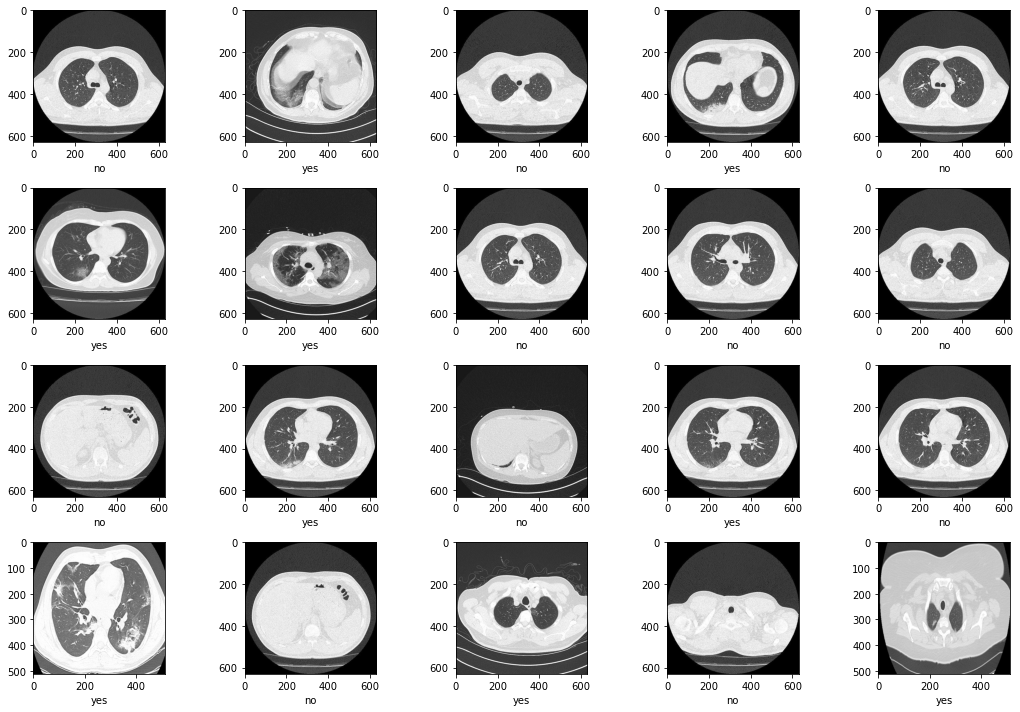

In [3]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, files in os.walk(img_path):
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = cv2.imread(file)
        plt.subplot(i,j,k)
        plt.imshow(img)
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(IMG_PATH)



## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

<img src="files/img.jpg">


**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

You can add your data augmentation methods here. Some simple example can be found at https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da.

In [4]:
TRAIN_DIR = 'Train_covid/'
VAL_DIR = 'Val_covid/'
IMG_SIZE = (224,224)
RANDOM_SEED = 100

train_datagen = ImageDataGenerator(
    #add your augmentation methods here
    preprocessing_function=preprocess_input,
    #rotation_range=15,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.1,
    #fill_mode='nearest',
    #horizontal_flip=True,
    #vertical_flip=True,
    #channel_shift_range=70,
    #rescale=1./255
    
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 0 images belonging to 2 classes.
Found 836 images belonging to 2 classes.


## Load the backbone model

To extract the features from the dataset, a backbone network is used here. Initially, VGG16 is used here as an example.


To achieve the best classification accuracy, you are encouraged to try different models. A list of models you can try is given at https://keras.io/api/applications/. Remember to update the **Preparing your environment** and **this** part to use a different backbone model, for instance, to use the ResNet50 as the backbone network, change 'from keras.applications.vgg16 import VGG16, preprocess_input' into 'from keras.applications.resnet_v2 import ResNet50, preprocess_input'

These models are pretrained on ImageNet dataset for classification task and you can choose to finetune the pretrained network (transfer learning: https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) or train it from the scratch for the lung image classification task.

VGG16: https://arxiv.org/pdf/1409.1556

ResNet: https://arxiv.org/abs/1512.03385

DenseNet: https://arxiv.org/abs/1608.06993

**Question**

What are the advantages and disadvantages of finetuning a model for lung image classification?

In [5]:
##迁移学习就是把已训练好的模型（预训练模型）参数迁移到新的模型来帮助新模型训练。我们可以将已经学到的模型参数（也可理解为模型学到的知识）
##通过某种方式来分享给新模型从而加快并优化模型的学习效率不用像大多数网络那样从零学习。
##包括三种手段：
##Transfer Learning：冻结预训练模型的全部卷积层，只训练自己定制的全连接层。
##Extract Feature Vector：先计算出预训练模型的卷积层对所有训练和测试数据的特征向量，然后抛开预训练模型，只训练自己定制的简配版全连接网络。
##Fine-tune：冻结预训练模型的部分卷积层（通常是靠近输入的多数卷积层），训练剩下的卷积层（通常是靠近输出的部分卷积层）和全连接层。

##优点
##在这次lung classification中使用finetuning能通过现有的模型确定此模型训练权重的初始值，提高效率，节省训练时间
##并且由于这次训练的图像数量偏少，导入imagenet等数据集能防止模型出现过拟合现象（即，当新问题的数据集很小时，直接训练容易过拟合，迁移学习可以有效避免这种情况。）

##缺点
##就是微调，但是什么才算微调呢？调整输入的结构？调整输出的结构？这并没有确切的概念，
##但主流观点还是认为调整并重新训练末尾几层的参数属于Fine-tuning。当然，绝大多数时候输入层也是需要微调的。

base_model =MobileNet(
    #uncomment if you want to train your network from scratch.
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

## Build the model for lung image classification

A classifier is added to the backbone network here. The loss function used to train the model is binary cross entropy (details can be found at https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class and https://machinelearningmastery.com/cross-entropy-for-machine-learning/). 

The optimizer used here is ADAM (https://arxiv.org/abs/1412.6980) and you can leave it unchanged.

In [6]:
NUM_CLASSES = 1

##sigmoid函数也叫Logistic函数，用于隐层神经元输出，取值范围为(0,1)，
##它可以将一个实数映射到(0,1)的区间，可以用来做二分类。
##相似的还有别的activation，比如SoftMax。
##当这些函数运用到中间laser的时候，一般是用来添加非线性关系

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________


## Train the model
The early stopping would stop the training process when a pre-defined metric stops improving. More details can be found at https://keras.io/api/callbacks/early_stopping/.

In [52]:
num_epochs = 200
earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)


Epoch 1/200
21/21 [==============================] - 11s 415ms/step - loss: 0.4157 - accuracy: 0.8657 - val_loss: 0.8787 - val_accuracy: 0.6928
Epoch 2/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0764 - accuracy: 0.9746 - val_loss: 0.5057 - val_accuracy: 0.8193
Epoch 3/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0325 - accuracy: 0.9881 - val_loss: 0.4182 - val_accuracy: 0.8554
Epoch 4/200
21/21 [==============================] - 8s 384ms/step - loss: 0.0139 - accuracy: 0.9940 - val_loss: 0.2336 - val_accuracy: 0.9036
Epoch 5/200
21/21 [==============================] - 8s 386ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss: 0.2328 - val_accuracy: 0.9277
Epoch 6/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0534 - val_accuracy: 0.9759
Epoch 7/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0028 - accuracy: 0.9985 - val_loss: 0.0431 - val_accuracy: 0.981

## Plot training result##

**Question**

What causes the gap between training accuracy/loss and test accuracy/loss? How do you reduce the gap between training accuracy/loss and test accuracy/loss?

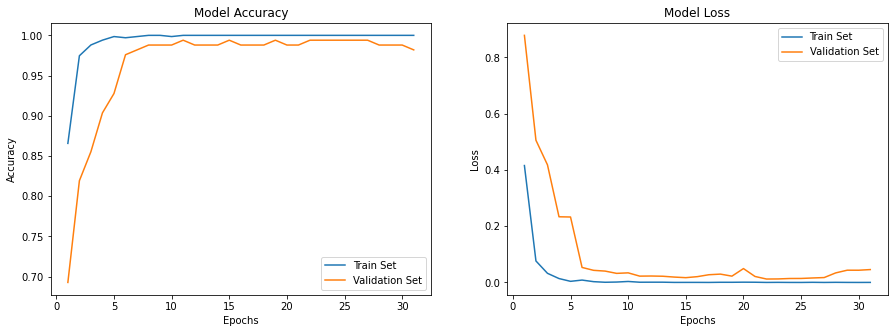

In [53]:
##The training loss indicates how well the model is fitting the training data, while the validation loss indicates 
##how well the model fits new data.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Save your trained model
If you feel your model has been trained to convergence, save it here.

In [28]:
#model.save('trained_model.h5')

## Validation
Test your trained model on validation set.

In [33]:
def load_data(dir_path, img_size=IMG_SIZE):
    X = []
    y = []
    i = 0
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(preprocess_input(img))
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

X_val, y_val = load_data(VAL_DIR)
predictions = model.predict(X_val)
print(predictions)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.03s/it]


836 images loaded from Val_covid/ directory.
27/27 [==============================] - 18s 692ms/step
[[1.04716138e-12]
 [4.98496253e-12]
 [1.75680900e-12]
 [4.39283289e-12]
 [3.17021843e-12]
 [3.59702502e-12]
 [5.97962435e-13]
 [6.44924869e-12]
 [1.07585010e-10]
 [2.66631717e-10]
 [1.66173169e-11]
 [4.42216611e-11]
 [1.30785816e-11]
 [2.14174633e-11]
 [5.09047145e-12]
 [3.83009466e-12]
 [4.35132139e-12]
 [5.92261223e-12]
 [7.74481347e-12]
 [3.67100751e-12]
 [9.60060915e-13]
 [1.93811269e-11]
 [7.29982047e-12]
 [4.77286136e-12]
 [1.32814038e-10]
 [8.86150944e-11]
 [1.19499921e-09]
 [4.04947881e-11]
 [4.96601371e-11]
 [1.69400570e-11]
 [2.25088021e-11]
 [2.22710322e-10]
 [4.23356662e-11]
 [4.13762635e-11]
 [9.45490821e-12]
 [2.56391441e-09]
 [6.71738576e-08]
 [6.87085988e-09]
 [1.67467142e-08]
 [1.97041725e-08]
 [8.54376569e-09]
 [7.45021378e-09]
 [3.97887012e-09]
 [8.78771189e-09]
 [3.38812143e-08]
 [2.70863421e-08]
 [8.58164313e-08]
 [2.19173970e-07]
 [4.98350755e-06]
 [4.55561851e-04]